In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import os
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()
DISPLAY = False # True/False para ver os displays

In [48]:
links_path = '../input/links.csv' # usando small pra ir mais rapido
df_links = spark.read.csv(links_path, header=True)

ratings_path = '../input/ratings.csv'# usando small pra ir mais rapido
df_ratings = spark.read.csv(ratings_path, header=True)

movies_metadata_path = '../input/movies_metadata.csv'
df_movies = spark.read.csv(movies_metadata_path, header=True)

keywords_path = '../input/keywords.csv'
df_keywords = spark.read.csv(keywords_path, header=True)

credits_path = '../input/credits.csv'
df_credits = spark.read.csv(credits_path, header=True)

### Movies_metadata

In [38]:
schema = T.ArrayType(T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("name", T.StringType(), True)
]))

w = Window().partitionBy('genres_explode.id')

df_genero = (
  df_movies
  .withColumn("genres_array", F.from_json("genres", schema))
  .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
  .filter(F.col('genres_array.name').isNotNull())
  .withColumn("genres_explode", F.explode("genres_array"))
  .withColumn('num_aparicao', F.count("*").over(w))
  .where(F.col("num_aparicao") > 2)
  .selectExpr('imdbId', 'genres_explode.name as genero')
  .groupBy("imdbId") 
  .pivot("genero") 
  .agg(F.lit(1)) 
  .na.fill(0)
)

In [77]:
df_preprocess = (
    df_movies
    .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
    .withColumn("adult", F.when(F.col("adult") == True, 1).otherwise(0))
    .withColumn("is_valid_title", F.when((F.col("title").cast(T.StringType()).isNotNull()) & (~F.col("title").rlike(r"[\[\]\{\}]")) & (~F.col("title").rlike(r"^\d+(\.\d+)?$")), True).otherwise(False))
    .filter(F.col("is_valid_title") == True)
    .withColumn("is_valid_overview", F.when((F.col("overview").cast(T.StringType()).isNotNull()) & (~F.col("overview").rlike(r"[\[\]\{\}]")) & (~F.col("overview").rlike(r"^\d+(\.\d+)?$")) & (F.length(F.col("overview")) >= 10), True).otherwise(False))
    .filter(F.col("is_valid_overview") == True)
    .withColumn("release_date", F.to_date(F.col("release_date"), "yyyy-MM-dd"))
    .withColumn('popularity', F.log1p(F.col('popularity').cast("float")))
    .withColumn('vote_average', F.col('vote_average').cast("float"))
    .filter((F.col('vote_average') >= 0) & (F.col('vote_average') <= 10))
    .withColumn('movie_overall_grade', F.round((F.col("vote_average")/10),2))
    .withColumn("movie_popularity", F.round(F.when(F.col("popularity")> 3, F.lit(1)).otherwise(F.col("popularity")/3),4))
    .select('imdbId', 'overview', 'adult', 'title', 'release_date',"movie_popularity","movie_overall_grade")
    .dropna()
    .join(df_genero, on=["imdbId"], how="inner")
)

    


In [40]:
df_preprocess.show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------------------------------------+------------+----------------+-------------------+------+---------+---------+------+-----+-----------+-----+------+-------+-------+-------+------+-------------+-----+-------+-------+---------------+--------+--------+---+-------+
|imdbId |overview                                                                                                                                                                                          

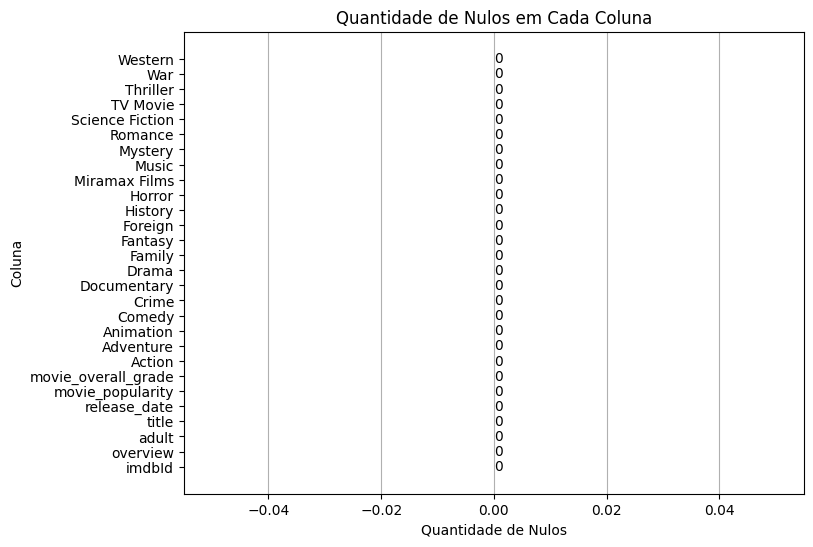

In [79]:
quantidade_nulos = [df_preprocess.filter(F.col(coluna).isNull()).count() for coluna in df_preprocess.columns]
nomes_colunas = df_preprocess.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()


In [78]:
print(df_preprocess.count())
print(df_movies.count())



38538
45572


### Credits

In [81]:
schema = T.ArrayType(T.StructType([
    T.StructField("cast_id", T.IntegerType(), True),
    T.StructField("character", T.StringType(), True),
    T.StructField("credit_id", T.StringType(), True),
    T.StructField("gender", T.IntegerType(), True),
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("order", T.IntegerType(), True),
    T.StructField("profile_path", T.StringType(), True)
]))

df_exploded = (
    df_credits
    .withColumn("cast", F.from_json("cast", schema))
    .withColumn("cast", F.explode("cast"))
)

df_cast = (
    df_exploded
    .filter(F.col("id").rlike("^\d+$"))
    .select(
        F.col("id").alias("movie_id"),
        F.col("cast.cast_id"),
        F.col("cast.character"),
        F.col("cast.credit_id"),
        F.col("cast.gender"),
        F.col("cast.id").alias("actor_id"),
        F.col("cast.name").alias("actor_name"),
    )
)

In [84]:
df_cast.show(truncate=False)

+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|movie_id|cast_id|character                   |credit_id               |gender|actor_id|actor_name               |
+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|15602   |2      |Max Goldman                 |52fe466a9251416c75077a8d|2     |6837    |Walter Matthau           |
|15602   |3      |John Gustafson              |52fe466a9251416c75077a91|2     |3151    |Jack Lemmon              |
|15602   |4      |Ariel Gustafson             |52fe466a9251416c75077a95|1     |13567   |Ann-Margret              |
|15602   |5      |Maria Sophia Coletta Ragetti|52fe466a9251416c75077a99|1     |16757   |Sophia Loren             |
|15602   |6      |Melanie Gustafson           |52fe466a9251416c75077a9d|1     |589     |Daryl Hannah             |
|15602   |9      |Grandpa Gustafson           |53e5fcc2c3a3684430000d65|2     |1

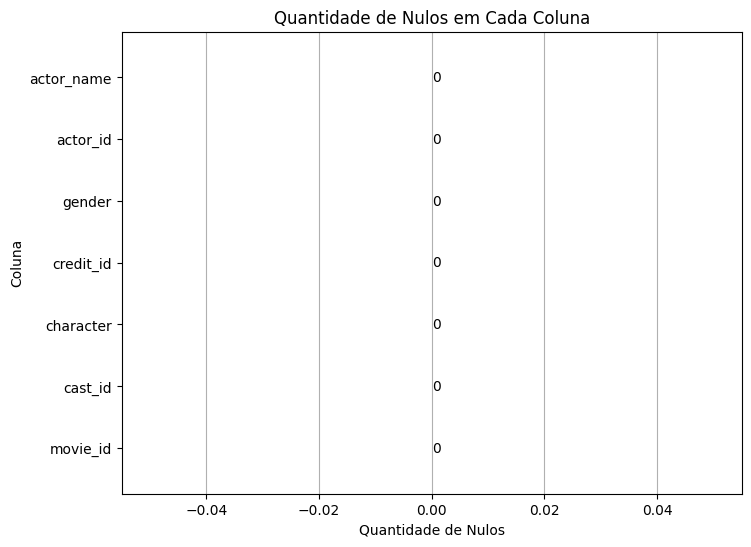

In [82]:
quantidade_nulos = [df_cast.filter(F.col(coluna).isNull()).count() for coluna in df_cast.columns]
nomes_colunas = df_cast.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [83]:
print(df_credits.count())
print(df_cast.count())

45476
59555


### Keywords

In [59]:
schema = T.ArrayType(T.StructType([
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True)
]))

df_exploded = (
    df_keywords
    .filter(F.col("id").rlike("^\d+$"))
    .withColumn("keywords", F.from_json("keywords", schema))
    .withColumn("keywords", F.explode("keywords"))
    .withColumn("keyword_name", F.trim(F.col("keywords.name")))
)

window_spec = Window.partitionBy("partition").orderBy(F.desc("count"))
df_keyword_counts = (
    df_exploded
    .groupBy("keyword_name")
    .count()
    .withColumn("partition", F.lit(1))  
    .withColumn("keyword_id", F.row_number().over(window_spec))
)

df_keyword_edit = (
    df_exploded
    .join(df_keyword_counts, on="keyword_name", how="inner")
    .select(
        F.col("id").alias("movie_id"),
        F.col("keyword_id"),
        F.col("keyword_name")
    )
)

In [60]:
df_keyword_edit.show(truncate=False)

+--------+----------+------------------------+
|movie_id|keyword_id|keyword_name            |
+--------+----------+------------------------+
|862     |75        |jealousy                |
|862     |1535      |toy                     |
|862     |341       |boy                     |
|862     |19        |friendship              |
|862     |92        |friends                 |
|862     |240       |rivalry                 |
|862     |6786      |boy next door           |
|862     |8870      |new toy                 |
|862     |1710      |toy comes to life       |
|15602   |1239      |fishing                 |
|15602   |152       |best friend             |
|15602   |18        |duringcreditsstinger    |
|15602   |9173      |old men                 |
|31357   |4         |based on novel          |
|31357   |837       |interracial relationship|
|31357   |388       |single mother           |
|31357   |143       |divorce                 |
|31357   |7543      |chick flick             |
|11862   |180

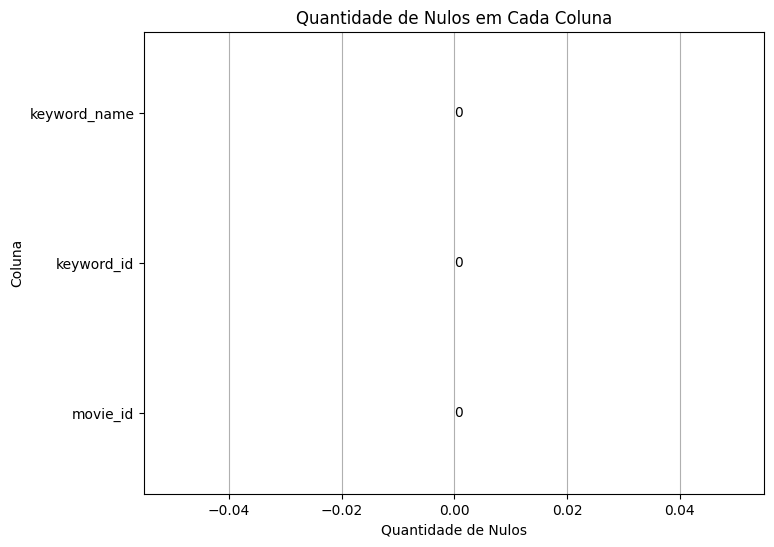

In [85]:
quantidade_nulos = [df_keyword_edit.filter(F.col(coluna).isNull()).count() for coluna in df_keyword_edit.columns]
nomes_colunas = df_keyword_edit.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [87]:
print(df_keywords.count())
print(df_keyword_edit.count())

46419
152592


### Ratings

In [62]:
df_ratings_2 = (
    df_ratings
    .withColumn('rating', F.round((F.col("rating")/5),2))
)

In [63]:
df_ratings_2.show(truncate=False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |110    |0.2   |1425941529|
|1     |147    |0.9   |1425942435|
|1     |858    |1.0   |1425941523|
|1     |1221   |1.0   |1425941546|
|1     |1246   |1.0   |1425941556|
|1     |1968   |0.8   |1425942148|
|1     |2762   |0.9   |1425941300|
|1     |2918   |1.0   |1425941593|
|1     |2959   |0.8   |1425941601|
|1     |4226   |0.8   |1425942228|
|1     |4878   |1.0   |1425941434|
|1     |5577   |1.0   |1425941397|
|1     |33794  |0.8   |1425942005|
|1     |54503  |0.7   |1425941313|
|1     |58559  |0.8   |1425942007|
|1     |59315  |1.0   |1425941502|
|1     |68358  |1.0   |1425941464|
|1     |69844  |1.0   |1425942139|
|1     |73017  |1.0   |1425942699|
|1     |81834  |1.0   |1425942133|
+------+-------+------+----------+
only showing top 20 rows



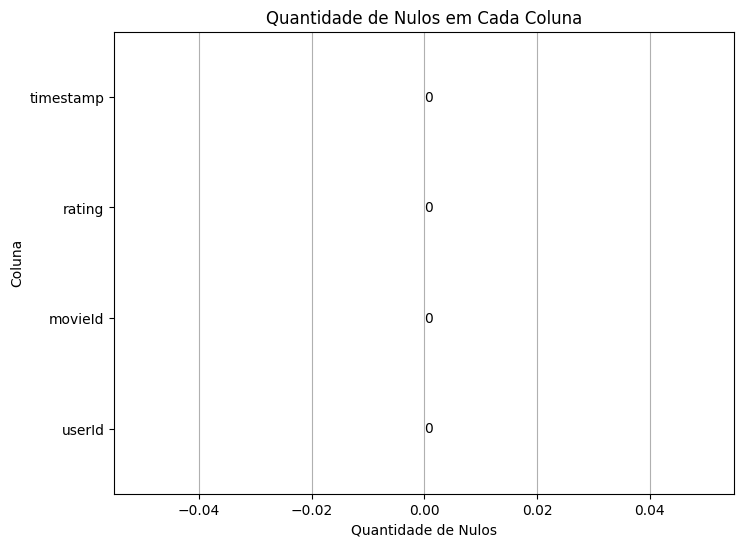

In [88]:
quantidade_nulos = [df_ratings_2.filter(F.col(coluna).isNull()).count() for coluna in df_ratings_2.columns]
nomes_colunas = df_ratings_2.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [89]:
print(df_ratings.count())
print(df_ratings_2.count())

26024289


26024289
